In [1]:
# OPTIONAL - sets the cells width of current notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
# import all necessary torch libraries
import torch
import torch.nn as nn
# sets output as wide as possible
torch.set_printoptions(edgeitems=30, linewidth=100000)
# data initialization
from dlc_practical_prologue import generate_pair_sets
nSamples = 1000
#data = generate_pair_sets(nSamples)
#var_names = ["train_input", "train_target", "train_classes", "test_input", "test_target", "test_classes"]
#train_input, train_target, train_classes, test_input, test_target, test_classes = data
#stringWidth = 20
#for i, el in enumerate(list(map(lambda x: (x.shape, x.dtype), data))):
#    print('{:s}  {:s}  {:s}'.format(
#        var_names[i].ljust(stringWidth),
#        ' x '.join(list(map(lambda x: str(x), list(el[0])))).center(stringWidth), 
#        'dtype'.ljust(stringWidth)))

## ConvNet

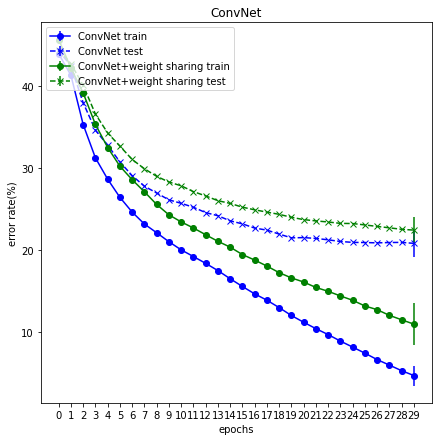

ConvNet final test accuracy: 20.84 ± 1.65 %
ConvNet + weight sharing final test accuracy: 22.45 ± 1.60 %
ConvNet num of params: 29833
ConvNet + weight sharing num of params: 24577
ConvNet train time: 11.50s ± 0.33s 
ConvNet + weight sharing train time: 11.89s ± 0.31s


In [7]:
from models.convnet import ConvNet
from utils import train_model
from utils import calculate_mean_std
from utils import num_of_train_param
import time

nb_epochs = 30
mini_batch_size = 100
#lrs = [0.000247, 0.000213]
lrs = [1e-4, 1e-4]
ws = [False, True]
formats = [['b-o', 'b--x'], ['g-o', 'g--x']]
labels = [['ConvNet train', 'ConvNet test'], 
          ['ConvNet+weight sharing train', 'ConvNet+weight sharing test']]
final_acc = [[0, 0], [0, 0]]
num_params = [0, 0]
nb_iter = 10
train_time = torch.empty(size=(2, nb_iter))

# initialize plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.xlabel('epochs')
plt.ylabel('error rate(%)')
plt.xticks(range(nb_epochs))

for k in [0, 1]:

    # average acuracy of the model over nb_iter runs
    train_accuracies = torch.tensor([])
    test_accuracies = torch.tensor([])
    train_losses = []
    
    for i in range(nb_iter):

        # create model & optimizer
        model = ConvNet(nb_channels=24, kernel_size=3, weight_sharing=ws[k])
        optimizer = torch.optim.Adam(model.parameters(), lr = lrs[k])
        criterion = nn.BCELoss()            

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
        # pad input to size 16 x 16 (power of 2, so that it can be run through 3 max-pool layers)
        train_input_cnn = torch.nn.functional.pad(train_input, (1, 1, 1, 1), 'constant', 0)
        test_input_cnn = torch.nn.functional.pad(test_input, (1, 1, 1, 1), 'constant', 0)
        
        # start training time
        start = time.time()

        # train model
        train_accuracy, test_accuracy, train_loss = train_model(model, 
                                                train_input_cnn, train_target.float(),
                                                test_input_cnn, test_target,
                                                nb_epochs, mini_batch_size,
                                                optimizer, criterion)
        
        # end training time
        end = time.time()
        train_time[k][i] = end - start
        
        # add accuracy stats
        train_accuracies = torch.cat([train_accuracies, train_accuracy], dim=0)
        test_accuracies = torch.cat([test_accuracies, test_accuracy], dim=0)
        #train_losses.append(train_loss)
        
    # calculate mean & std over nb_iters runs
    train_mean, train_std, test_mean, test_std = calculate_mean_std(train_accuracies, test_accuracies, train_losses)
    
    # plot accuracy of the model
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt=formats[k][0], label=labels[k][0])
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt=formats[k][1], label=labels[k][1])
    
    # final accuracy
    final_acc[k][0] = test_mean[-1]
    final_acc[k][1] = test_std[-1]
    
    # complexity of the model
    num_params[k] = num_of_train_param(model)
        
# show plot
plt.legend(loc="upper left")
plt.title("ConvNet")
plt.savefig('accuracy/ConvNet_er.png')
plt.show()

# final test accuracy
print("ConvNet final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[0][0],
                                                                   final_acc[0][1]))
print("ConvNet + weight sharing final test accuracy: {:.2f} \u00B1 {:.2f} %".format(final_acc[1][0],
                                                                                    final_acc[1][1]))
# model complexity
print("ConvNet num of params: {:d}".format(num_params[0]))
print("ConvNet + weight sharing num of params: {:d}".format(num_params[1]))
# training time
time_std, time_mean = torch.std_mean(train_time, dim=1)
print("ConvNet train time: {:.2f}s \u00B1 {:.2f}s ".format(time_mean[0],
                                                          time_std[0]))
print("ConvNet + weight sharing train time: {:.2f}s \u00B1 {:.2f}s".format(time_mean[1],
                                                                           time_std[1]))

## Net1

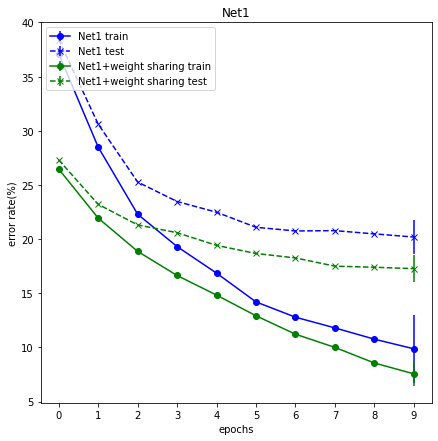

Net1 final test error rate: 20.19 ± 1.57 %
Net1 + weight sharing final test error rate: 17.27 ± 1.24 %
Net1 num of params: 48850
Net1 + weight sharing num of params: 24425
Net1 train time: 3.19s ± 0.11s 
Net1 + weight sharing train time: 3.02s ± 0.14s


In [6]:
from utils import train_model
from utils import calculate_mean_std
from utils import num_of_train_param
from models.net1 import Net1
import time

# initialize parameters
mini_batch_size = 100
nb_epochs = 10
etas = [0.000483, 0.000399]
ws = [False, True]
formats = [['b-o', 'b--x'], ['g-o', 'g--x']]
labels = [['Net1 train', 'Net1 test'], 
          ['Net1+weight sharing train', 'Net1+weight sharing test']]
final_acc = [[0, 0], [0, 0]]
num_params = [0, 0]
nb_iter = 10
train_time = torch.empty(size=(2, nb_iter))

# initialize plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.xlabel('epochs')
plt.ylabel('error rate(%)')
plt.xticks(range(nb_epochs))

for k in [0, 1]:

    # average acuracy of the model over nb_iter runs
    train_accuracies = torch.tensor([])
    test_accuracies = torch.tensor([])
    train_losses = []
    
    for i in range(nb_iter):

        # create model & optimizer
        model = Net1(weight_sharing=ws[k])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = etas[k])

        # load data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
        
        # start training time
        start = time.time()

        # train model
        train_accuracy, test_accuracy, _ = train_model(model, 
                                                       train_input, train_target.float(),
                                                       test_input, test_target,
                                                       nb_epochs, mini_batch_size,
                                                       optimizer, criterion)
        
        # end training time
        end = time.time()
        train_time[k][i] = end - start

        # add accuracy stats
        train_accuracies = torch.cat([train_accuracies, train_accuracy], dim=0)
        test_accuracies = torch.cat([test_accuracies, test_accuracy], dim=0)
        #train_losses.append(train_loss)
        
    # calculate mean & std over nb_iters runs
    train_mean, train_std, test_mean, test_std = calculate_mean_std(train_accuracies, test_accuracies, train_losses)
    
    # plot accuracy of the model
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt=formats[k][0], label=labels[k][0])
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt=formats[k][1], label=labels[k][1])
    
    # final accuracy
    final_acc[k][0] = test_mean[-1]
    final_acc[k][1] = test_std[-1]
    
    # complexity of the model
    num_params[k] = num_of_train_param(model)
    
# show plot
plt.legend(loc="upper left")
plt.title("Net1")
plt.savefig("accuracy/Net1_er.png")
plt.show()
# final test accuracy
print("Net1 final test error rate: {:.2f} \u00B1 {:.2f} %".format(final_acc[0][0],
                                                                final_acc[0][1]))
print("Net1 + weight sharing final test error rate: {:.2f} \u00B1 {:.2f} %".format(final_acc[1][0],
                                                                                 final_acc[1][1]))
# model complexity
print("Net1 num of params: {:d}".format(num_params[0]))
print("Net1 + weight sharing num of params: {:d}".format(num_params[1]))
# training time
time_std, time_mean = torch.std_mean(train_time, dim=1)
print("Net1 train time: {:.2f}s \u00B1 {:.2f}s ".format(time_mean[0],
                                                        time_std[0]))
print("Net1 + weight sharing train time: {:.2f}s \u00B1 {:.2f}s".format(time_mean[1],
                                                                        time_std[1]))

## Net2

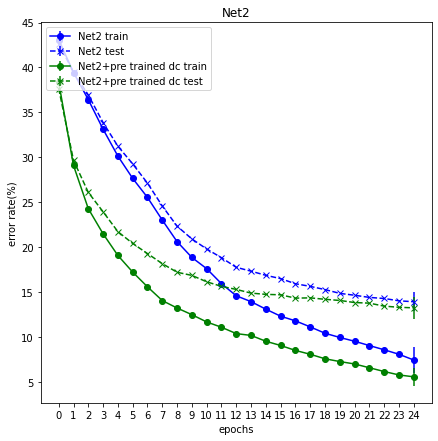

Net2 final test error rate: 13.92 ± 1.09 %
Net2 + pre-trained dc final test error rate: 13.24 ± 1.22 %
Net1 num of params: 25345
Net1 + weight sharing num of params: 25345
Net2 train time: 7.78s ± 0.39s 
Net2 + pre trained dc train time: 7.89s ± 0.20s


In [9]:
from utils import train_model
from utils import train_model_double_objective
from utils import accuracy_of_digit_class
from utils import calculate_mean_std
from models.net2 import Net2
from models.digit_classifier import DigitClassifier
import time

# digit classifier params
mini_batch_size_dc = 100
eta_dc = 1e-3
nb_epochs_dc = 20
# net2 params
mini_batch_size = 100
nb_epochs = 25
etas = [0.000483, 0.000263]
pre_train = [False, True]
formats = [['b-o', 'b--x'], ['g-o', 'g--x']]
labels = [['Net2 train', 'Net2 test'], 
          ['Net2+pre trained dc train', 'Net2+pre trained dc test']]
final_acc = [[0, 0], [0, 0]]
num_params = [0, 0]
nb_iter = 10
train_time = torch.empty(size=(2, nb_iter))

# initialize plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.xlabel('epochs')
plt.ylabel('error rate(%)')
plt.xticks(range(nb_epochs))

for k in [0, 1]:

    # average acuracy of the model over nb_iter runs
    train_accuracies = torch.tensor([])
    test_accuracies = torch.tensor([])
    train_losses = []
    
    for i in range(nb_iter):
        
        # pre-train digit classifier
        model_classifier = None
        train_input, train_target, train_classes, test_input, test_target, test_classes = None, None, None, None, None, None
        if pre_train[k]:
            
            # create digit classifier model & optimizer
            model_classifier = DigitClassifier(out_h = 10, subnet = False)
            optimizer = torch.optim.Adam(model_classifier.parameters(), lr = eta_dc)
            criterion = nn.CrossEntropyLoss()

            # load data
            train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)

            # data for digit classifier
            train_in = train_input[:, 0, :, :].unsqueeze(axis = 1)
            train_class = train_classes[:,0]
            test_in = test_input[:, 0, :, :].unsqueeze(axis = 1)
            test_class = test_classes[:,0]

            # train digit classifier model
            train_accuracy_dc, test_accuracy_dc, train_loss_dc = train_model(model_classifier, 
                                                                             train_in, train_class,
                                                                             test_in, test_class,
                                                                             nb_epochs_dc, mini_batch_size_dc, 
                                                                             optimizer, criterion)

        # create model & optimizer
        model = Net2(pretrained_submodel = model_classifier)
        criterion = nn.BCEWithLogitsLoss()
        criterion2 = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = etas[k])

        # load data
        if not pre_train[k]:
            train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(nSamples)
            
        # start time
        start = time.time()

        # train model
        train_accuracy, test_accuracy, _ = train_model_double_objective(model, train_input, train_target.float(), 
                                                         train_classes, test_input, test_target, 
                                                         test_classes, nb_epochs, mini_batch_size, optimizer, 
                                                         criterion, criterion2, beta = 1)
        
        # end training time
        end = time.time()
        train_time[k][i] = end - start

        # add accuracy stats
        train_accuracies = torch.cat([train_accuracies, train_accuracy], dim=0)
        test_accuracies = torch.cat([test_accuracies, test_accuracy], dim=0)
        #train_losses.append(train_loss)

    # calculate mean & std over nb_iters runs
    train_mean, train_std, test_mean, test_std = calculate_mean_std(train_accuracies, test_accuracies, train_losses)

    # plot accuracy of the model
    plt.errorbar(range(nb_epochs), train_mean, yerr=train_std, fmt=formats[k][0], label=labels[k][0])
    plt.errorbar(range(nb_epochs), test_mean, yerr=test_std, fmt=formats[k][1], label=labels[k][1])
    
    # final accuracy
    final_acc[k][0] = test_mean[-1]
    final_acc[k][1] = test_std[-1]
    
    # complexity of the model
    num_params[k] = num_of_train_param(model)
    
# show plot
plt.legend(loc="upper left")
plt.title("Net2")
plt.savefig("accuracy/Net2.png")
plt.show()
# final test accuracy
print("Net2 final test error rate: {:.2f} \u00B1 {:.2f} %".format(final_acc[0][0],
                                                                final_acc[0][1]))
print("Net2 + pre-trained dc final test error rate: {:.2f} \u00B1 {:.2f} %".format(final_acc[1][0],
                                                                                 final_acc[1][1])) 
# model complexity
print("Net1 num of params: {:d}".format(num_params[0]))
print("Net1 + weight sharing num of params: {:d}".format(num_params[1]))
# training time
time_std, time_mean = torch.std_mean(train_time, dim=1)
print("Net2 train time: {:.2f}s \u00B1 {:.2f}s ".format(time_mean[0],
                                                        time_std[0]))
print("Net2 + pre trained dc train time: {:.2f}s \u00B1 {:.2f}s".format(time_mean[1],
                                                                        time_std[1]))